Задание

Цель: разработать скрипт для сбора и обработки данных с использованием API Binance и прогнозирования временных рядов с помощью LSTM-модели.

In [1]:
import requests 
import json 
import pandas as pd 
import numpy as np  
import datetime as dt  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
random.seed(10)

In [137]:
#будем анализировать BTCUSDT c частотой 5 минут и числом наблюдений 1000
frequency = input("Please enter the frequency (1m/5m/30m/.../1h/6h/1d/ :  ")

def get_bars(symbol, interval=frequency):
    root_url = 'https://api.binance.com/api/v3/klines'
    url = root_url + '?symbol=' + symbol + '&interval=' + interval + '&limit=1000' 
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                  'open_price', 'high', 'low', 'close', 'volume',
                  'close_time', 'qav', 'num_trades',
                  'taker_base_vol', 'taker_quote_vol', 'ignore']
    df['date_open'] = pd.to_datetime(df['open_time'], unit = 'ms')
    #df['date_close'] = pd.to_datetime(df['close_time'], unit = 'ms')
    return df

btcusdt = get_bars('BTCUSDT')



df0=pd.DataFrame(btcusdt)
df0.to_csv('_btcusdt.csv')

In [2]:
#в качестве целевого признака примем open_price
data = pd.read_csv('_btcusdt.csv')
data = data.drop(['Unnamed: 0', 'ignore', 'open_time', 'close_time'], axis = 1)
data.tail()


,open_price,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,date_open
995,28013.99,28013.99,28013.90,28013.91,21.37021,5.986644e+05,1169,11.46302,321124.750947,2023-04-08 05:25:00
996,28013.91,28032.18,28013.90,28031.62,34.22481,9.589740e+05,1358,21.03777,589467.772124,2023-04-08 05:30:00
997,28031.62,28032.17,28028.93,28029.45,42.51748,1.191782e+06,1258,13.57309,380455.535780,2023-04-08 05:35:00
998,28029.45,28041.68,28029.45,28041.67,56.53980,1.585209e+06,1789,33.57187,941257.259329,2023-04-08 05:40:00
999,28041.68,28046.08,28041.67,28046.08,8.54891,2.397313e+05,183,4.53500,127171.602821,2023-04-08 05:45:00


In [3]:
data.isna().sum()# нет Nan

open_price         0
high               0
low                0
close              0
volume             0
qav                0
num_trades         0
taker_base_vol     0
taker_quote_vol    0
date_open          0
dtype: int64

In [4]:
data0 = data[['open_price', 'date_open']]
data0.index = pd.to_datetime(data0['date_open'], unit = 'ns')
data0 = data0.drop(['date_open'], axis = 1)
data0

,open_price
date_open,
2023-04-04 18:30:00,28123.18
2023-04-04 18:35:00,28136.10
2023-04-04 18:40:00,28135.69
2023-04-04 18:45:00,28187.48
2023-04-04 18:50:00,28164.39
...,...
2023-04-08 05:25:00,28013.99
2023-04-08 05:30:00,28013.91
2023-04-08 05:35:00,28031.62


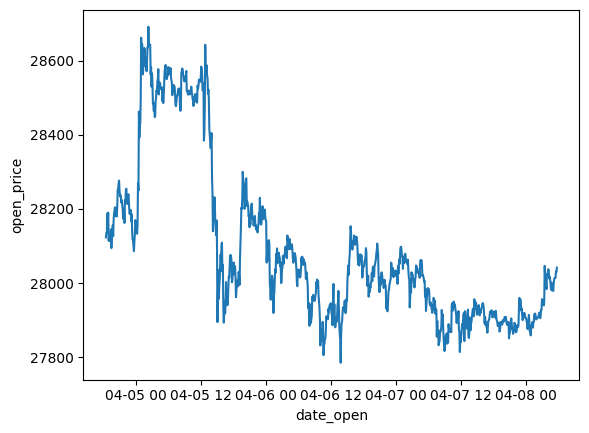

In [5]:
#посмотрим на график для цен на открытие, видно что он нестационарный. В данной работе не будем обрабатывать аномалиии
plt.plot(data0.index, data0['open_price'])
plt.xlabel("date_open")
plt.ylabel("open_price")

plt.show()

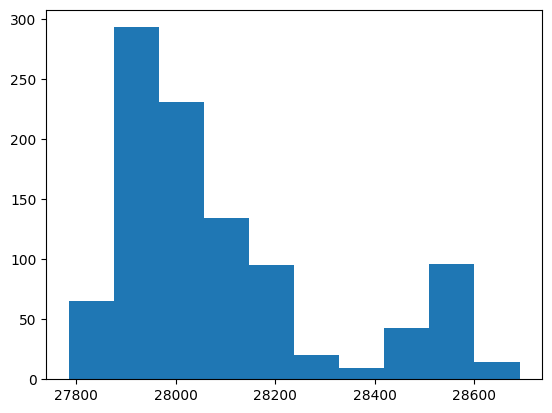

,open_price
count,1000.000000
mean,28091.944080
std,218.395211
min,27785.110000
25%,27925.097500
50%,28025.010000
75%,28171.300000
max,28691.280000


In [6]:
#видно что данные имеют бимодальное распределение
itg = data0.describe()
plt.hist(data0)
plt.show()
itg

In [7]:
#ряд более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации
data0.std()/data0.mean()

open_price    0.007774
dtype: float64

In [8]:
#Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности.
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jarque_bera(data0)
a = np.vstack([jb_test])
a, row
#Значение данной статистики свидетельствует о том, нулевая гипотеза о нормальности распределения
#  отвергается с малой вероятностью (probably > 0.05), 
# и, следовательно, наш ряд имеет нормальное распределения. Хотя по графику я бы так не сказал

(array([[2.23699405e+02],
        [2.65638705e-49],
        [1.15494328e+00],
        [3.18223562e+00]]),
 ['JB', 'p-value', 'skew', 'kurtosis'])

In [9]:
#Проверим, являются ли данные стационарным временным рядом, для этого существует обобщенный тест Дикки-Фуллера(например,
#  теорема Волда утверждает что любой стационарный ряд может быть описан моделью ARIMA с любой точностью)
test = adfuller(data0)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -1.8401090361054229
p-value:  0.3607382198733019
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
есть единичные корни, ряд не стационарен


In [10]:
#За счет дифф ряда мы можем стабилизировать среднее значение ряда и избавиться от тренда 
test = adfuller(data0.diff(periods=1).dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -36.154102079574095
p-value:  0.0
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
единичных корней нет, ряд стационарен


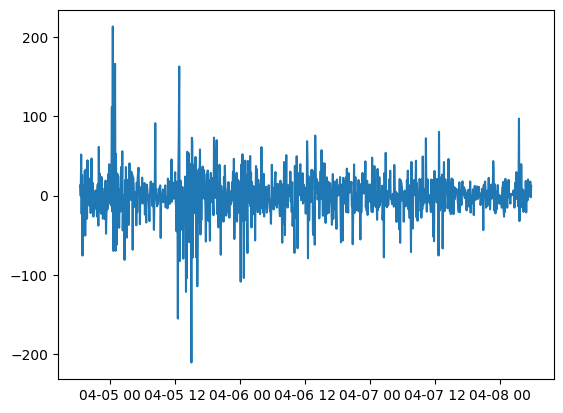

In [11]:
#Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным
plt.plot(data0['open_price'].diff(periods=1).dropna())


plt.show()

In [12]:
#разделение выборки
train_size = int(len(data0) * 0.988)
X_train, X_test = pd.DataFrame(data0.iloc[:train_size, -1]), pd.DataFrame(data0.iloc[train_size:, -1])

In [13]:
X_train.shape, X_test.shape

((988, 1), (12, 1))

In [14]:
X_train

,open_price
date_open,
2023-04-04 18:30:00,28123.18
2023-04-04 18:35:00,28136.10
2023-04-04 18:40:00,28135.69
2023-04-04 18:45:00,28187.48
2023-04-04 18:50:00,28164.39
...,...
2023-04-08 04:25:00,28017.56
2023-04-08 04:30:00,28010.01
2023-04-08 04:35:00,27998.00


In [15]:
#Нормализация
scaler_X = MinMaxScaler()
X_train_nor = scaler_X.fit_transform(X_train)
X_test_nor = scaler_X.transform(X_test)


Одномерный временной ряд

In [16]:
#Для сравнения с LSTM будем использовать ARIMA
from pmdarima import auto_arima

sarimax_param = auto_arima(X_train_nor, exogenous=X_train_nor, m=10, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=-3286.992, Time=1.60 sec
 ARIMA(1,1,0)(1,1,0)[10]             : AIC=-3569.093, Time=1.27 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=inf, Time=5.40 sec
 ARIMA(1,1,0)(0,1,0)[10]             : AIC=-3295.634, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[10]             : AIC=-3670.806, Time=2.25 sec
 ARIMA(1,1,0)(3,1,0)[10]             : AIC=-3698.837, Time=2.62 sec
 ARIMA(1,1,0)(3,1,1)[10]             : AIC=inf, Time=19.78 sec
 ARIMA(1,1,0)(2,1,1)[10]             : AIC=inf, Time=11.78 sec
 ARIMA(0,1,0)(3,1,0)[10]             : AIC=-3685.729, Time=5.25 sec
 ARIMA(2,1,0)(3,1,0)[10]             : AIC=-3697.333, Time=4.79 sec
 ARIMA(1,1,1)(3,1,0)[10]             : AIC=-3697.345, Time=6.97 sec
 ARIMA(0,1,1)(3,1,0)[10]             : AIC=-3698.022, Time=18.52 sec
 ARIMA(2,1,1)(3,1,0)[10]             : AIC=-3695.307, Time=9.80 sec
 ARIMA(1,1,0)(3,1,0)[10] intercept   : AIC=-3696.837, Time=13.90 sec

Best model:  ARIMA

In [17]:
sarimax_param.get_params()["order"], sarimax_param.get_params()["seasonal_order"]

((1, 1, 0), (3, 1, 0, 10))

c:\Users\dmoro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


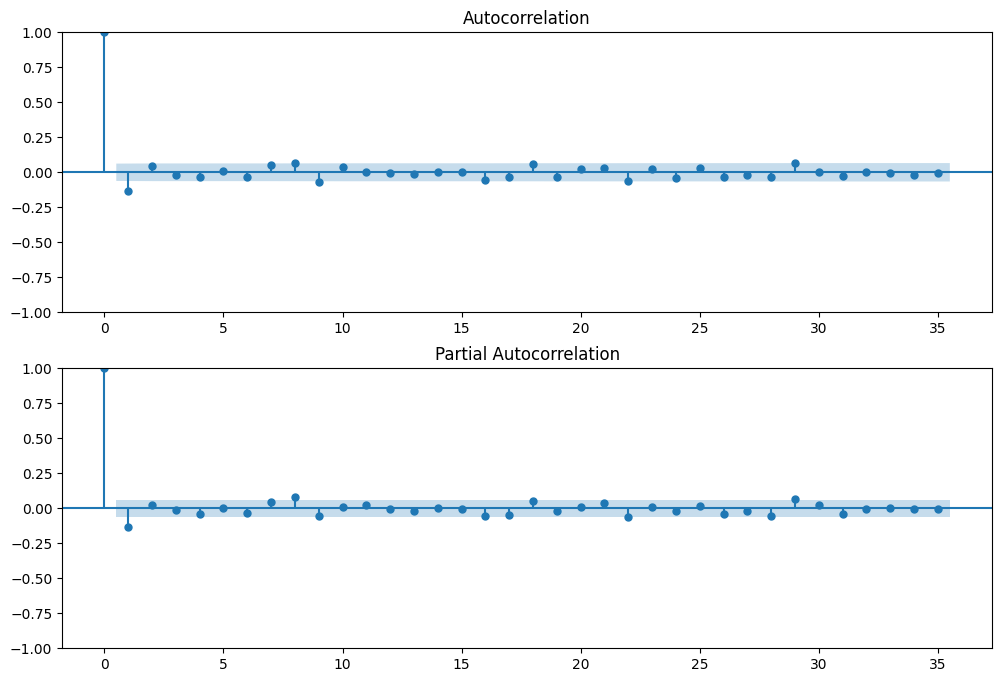

In [18]:
#ACF поможет определить q, т. к. по ее коррелограмме можно определить
#  количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
#PACF поможет нам определить p, т. к. по ее коррелограмме можно определить
#  максимальный номер коэффициента сильно отличный от 0 в модели AR.
#сравним с автоподбором
# в целом автоподбор выбрал правильные параметры
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data0.diff(periods=1).dropna().values.squeeze(), lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data0.diff(periods=1).dropna(), lags=35, ax=ax2)

In [19]:
model = SARIMAX(endog = X_train_nor, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"]).fit(full_output=False, disp=0)

In [20]:
#Как видно из данной информации все коэффициенты значимые и можно перейти к оценке модели.
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  988
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 10)   Log Likelihood                1854.418
Date:                            Tue, 11 Apr 2023   AIC                          -3698.837
Time:                                    08:51:28   BIC                          -3674.414
Sample:                                         0   HQIC                         -3689.544
                                            - 988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1251      0.024     -5.183      0.000      -0.172      -0.078
ar.S.L10      -0.7118      0.023   

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# forecast the data
forecast = model.get_prediction(start=len(X_train_nor), end=len(X_train_nor)+len(X_test_nor)-1, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(X_test, scaler_X.inverse_transform([prediction])[0], squared=False)
rmse = mean_squared_error(X_test, scaler_X.inverse_transform([prediction])[0], squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 16.572175 
RMSE = 274.636987


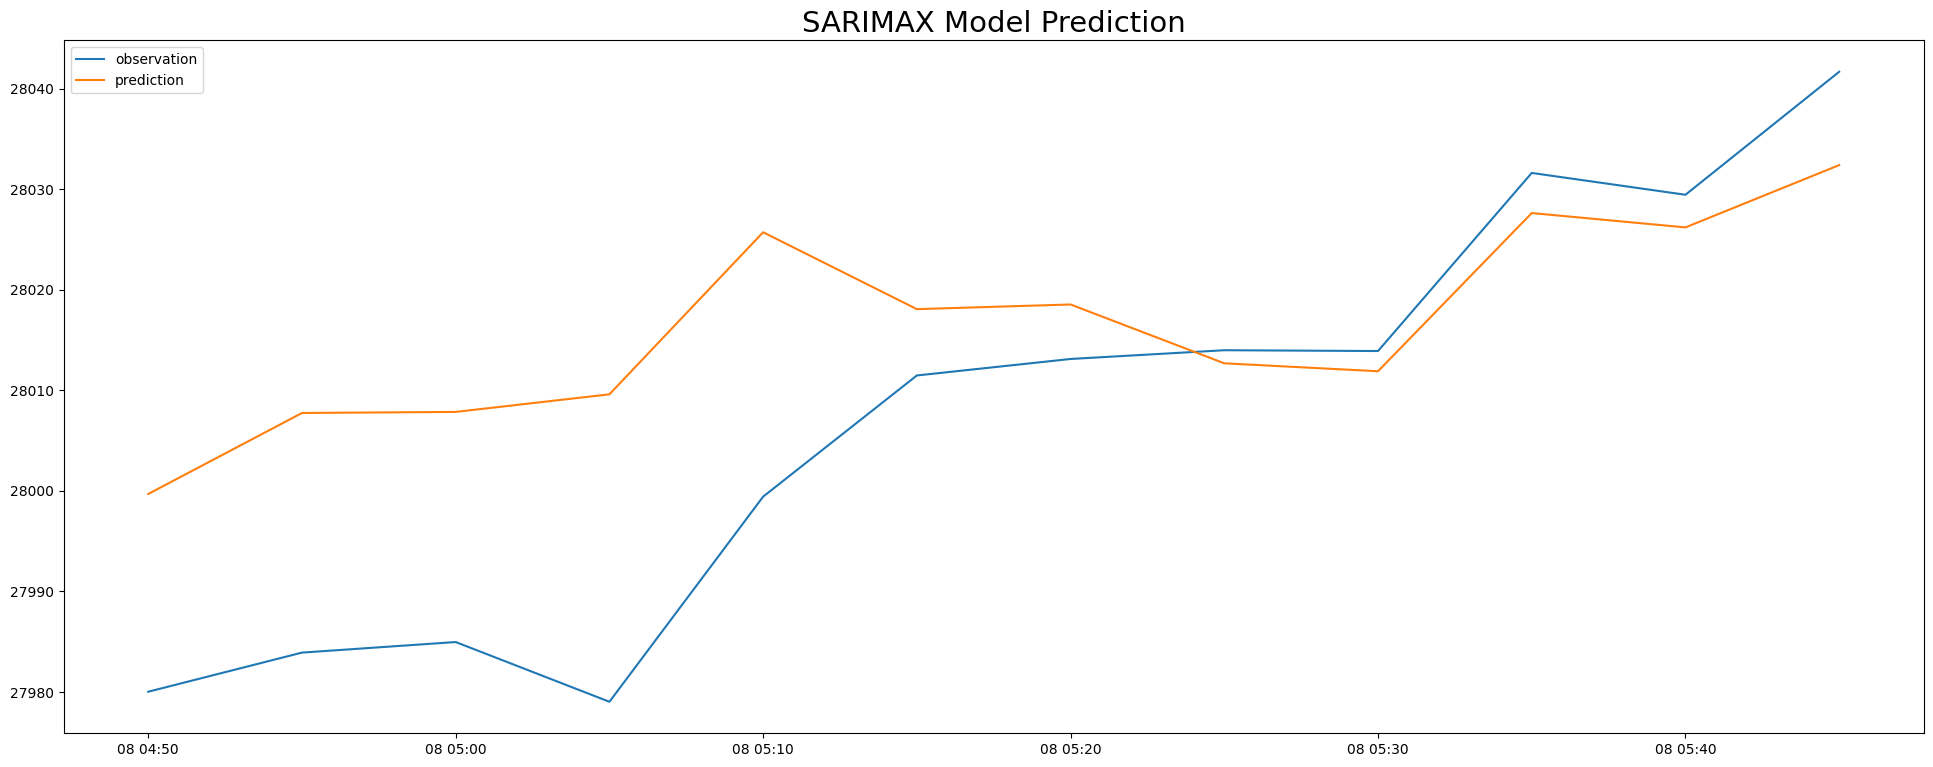

In [22]:
#получили не очень хороший прогноз
plt.figure(figsize=(24, 9))
plt.plot(X_test.index, X_test, label="observation")
plt.plot(X_test.index, scaler_X.inverse_transform([prediction])[0], label="prediction")
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

In [23]:
#Проверим остатки данной модели на соответствие «белому шуму»
#Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается,
# и скорее всего данный процесс представляет «белый шум».
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.001516  0.968940
1    1.034052  0.596291
2    1.034459  0.792915
3    1.357639  0.851523
4    1.530729  0.909497
5    3.275590  0.773547
6    5.426234  0.608096
7    7.964347  0.436961
8    9.926802  0.356443
9   17.319368  0.067589
10  17.601027  0.091312
11  18.719382  0.095529
12  19.050130  0.121558
13  20.160556  0.125160
14  20.339975  0.159275
15  22.215281  0.136375
16  22.760510  0.157211
17  25.828924  0.103734
18  26.079376  0.127992
19  32.182799  0.041389
20  32.845378  0.047960
21  37.471722  0.020985
22  37.552373  0.028433
23  37.591925  0.038156
24  37.776067  0.048641
25  37.878066  0.062158
26  38.856088  0.065292
27  39.528936  0.072783
28  45.944650  0.023764


Такие плохие результаты могут быть обоснованы наличием аномалий, ARIMA к ним очень чуствителен

LSTM

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [44]:
num_shape = 988

train = data0.iloc[:num_shape, ].values
test = data0.iloc[num_shape:, ].values

In [47]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [49]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [50]:
print(X_train.shape)
X_train

(928, 60, 1)


array([[[0.37307569],
        [0.3873335 ],
        [0.38688105],
        ...,
        [0.44252182],
        [0.38948542],
        [0.36643235]],

       [[0.3873335 ],
        [0.38688105],
        [0.44403368],
        ...,
        [0.38948542],
        [0.36643235],
        [0.36584747]],

       [[0.38688105],
        [0.44403368],
        [0.41855281],
        ...,
        [0.36643235],
        [0.36584747],
        [0.34661267]],

       ...,

       [[0.14592185],
        [0.14753302],
        [0.14857036],
        ...,
        [0.25079179],
        [0.2565192 ],
        [0.24818743]],

       [[0.14753302],
        [0.14857036],
        [0.14517144],
        ...,
        [0.2565192 ],
        [0.24818743],
        [0.23493384]],

       [[0.14857036],
        [0.14517144],
        [0.13369456],
        ...,
        [0.24818743],
        [0.23493384],
        [0.21798338]]])

In [51]:
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [52]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 [==============================] - 19s 182ms/step - loss: 0.0376
Epoch 2/100
29/29 [==============================] - 5s 170ms/step - loss: 0.0114
Epoch 3/100
29/29 [==============================] - 5s 180ms/step - loss: 0.0098
Epoch 4/100
29/29 [==============================] - 5s 172ms/step - loss: 0.0085
Epoch 5/100
29/29 [==============================] - 4s 152ms/step - loss: 0.0084
Epoch 6/100
29/29 [==============================] - 4s 150ms/step - loss: 0.0080
Epoch 7/100
29/29 [==============================] - 5s 157ms/step - loss: 0.0069
Epoch 8/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0064
Epoch 9/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0064
Epoch 10/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0062
Epoch 11/100
29/29 [==============================] - 4s 149ms/step - loss: 0.0060
Epoch 12/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0060
Epoch 13/100

In [53]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [54]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

1/1 [==============================] - 3s 3s/step


In [55]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 286.3363539718603
MAE: 14.440566406249976
RMSE: 16.92147611681263


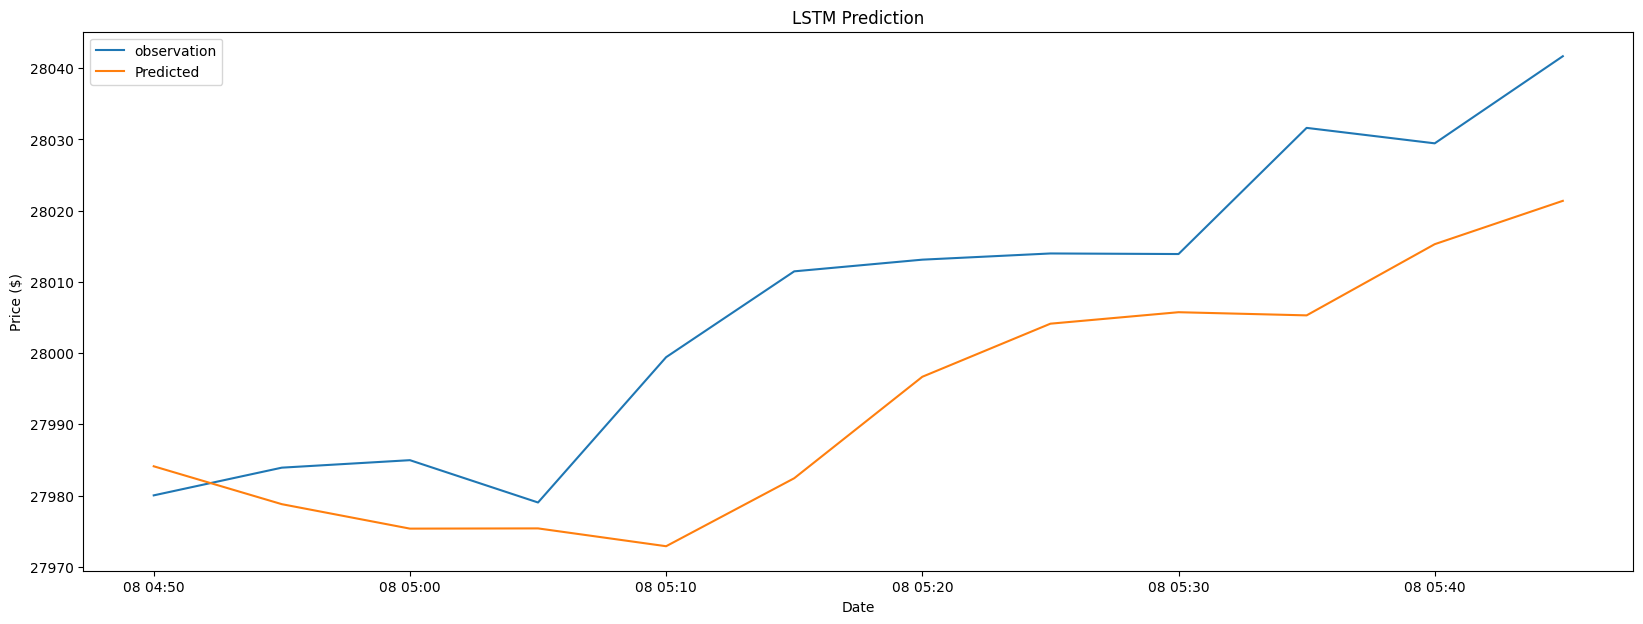

In [77]:
plt.figure(figsize=(20,7))
plt.plot(data0.index[988:], df_volume[988:], label = 'observation')
plt.plot(data0.index[988:][-predict.shape[0]:], predict,  label = 'Predicted')
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()